# 第14章 階層帰属意識のモデル(3)：シミュレーション

第12章・第13章で学んだFararo-Kosakaモデル（FKモデル）をRでシミュレーションします．

**この章の目標**:
- `FK()` 関数を実装してFKモデルの均衡イメージを計算する
- 2×2・2×3など具体的な客観階層構造でシミュレーションし，意識分布を確認する
- 次元数 $s$・ランク数 $r$ を変えながら，中意識集中現象がどのような条件で生じるかを探る
- 次元数 $s$ が増えると分布が正規分布に近づくことを中心極限定理から理解する

*このノートブックは Claude Sonnet 4.6 を利用して作成しました．*

---

## 14.1 FKモデルのシミュレーション関数

第12章・第13章で学んだFKモデルの公理系を振り返ります．

**公理1（多次元的階層構造）**: $s$ 個の次元（特性 $C_1, \ldots, C_s$）それぞれに $r$ 個のランクがある．

**公理2（手がかり抽出）**: 行為者 $\alpha$ が $\beta$ と相互作用するとき，$C_1$ から順に $\beta$ のランクを抽出し，$\alpha$ と異なるランクが見つかった時点で停止する．

**公理3（イメージ修正）**: 抽出された $\beta$ の位置 $Cl(\beta)$ に基づき，$\alpha$ のイメージを修正する（中間に挿入，最上位・最下位の更新）．

**公理4（帰属意識表明）**: $\alpha$ は均衡イメージにおける自身の相対的位置（ランク $\rho$）を階層帰属意識として表明する．

これをRで実装します．

**キー変数**:
- `obj`：客観階層構造（各行が1人の行為者，各列が1つの次元）
- `im`：各行為者 $k$ が各他者 $j$ との相互作用で抽出するイメージ
- `eqim`：各行為者の均衡イメージ（一意にまとめたもの）
- `ci`：各行為者の階層帰属意識（均衡イメージ上のランク $\rho$）

In [1]:
# FKモデルのシミュレーション関数
# 引数 obj：expand.grid() で生成した客観階層構造（data.frame）
# 返値：階層帰属意識のベクトル ci（ランク値）
FK <- function(obj, verbose = TRUE) {
  # 列順を逆にする（expand.grid の出力を上位ランクが先になるよう調整）
  obj <- obj[seq(ncol(obj), 1)]
  colnames(obj) <- NULL
  obj <- as.matrix(obj)
  
  n  <- nrow(obj)  # 行為者数（＝ r^s）
  s  <- ncol(obj)  # 次元数
  
  # im[j, i, k]：行為者 k が 他者 j を観察したとき，次元 i について抽出するイメージ
  im <- replicate(n, replicate(s, replicate(n, " ")))
  
  for (k in 1:n) {           # 観察者
    for (j in 1:n) {         # 被観察者
      for (i in 1:s) {       # 次元（公理2：C_1 から順に）
        if (obj[k, i] == obj[j, i]) {
          # 同じランク → そのランクをイメージに記録，次の次元へ
          im[[j, i, k]] <- obj[k, i]
        } else {
          # 異なるランク → j のランクを記録して停止（公理2）
          im[[j, i, k]] <- obj[j, i]
          break
        }
      }
    }
  }
  
  # 各行為者 k の均衡イメージを整理（各他者の地位文字列を生成）
  eqim <- data.frame(
    lapply(1:n, function(k)
      apply(im[, , k], 1, function(x) paste(x, collapse = "")))
  )
  colnames(eqim) <- apply(obj, 1, function(x) paste(x, collapse = ""))
  
  if (verbose) print(eqim)
  
  # 各行為者の階層帰属意識：均衡イメージ上での自分のランク順位
  ci <- sapply(1:ncol(eqim), function(k)
    grep(colnames(eqim)[k], unique(eqim[, k])))
  
  return(ci)
}

---

## 14.2 具体例：2次元2ランク（$s=2, r=2$）

第12章で確認した最もシンプルなケース，2次元×2ランクの客観階層構造からはじめます．

客観階層は $2^2 = 4$ 個のポジション（HH, HL, LH, LL）になります．

In [2]:
# 2次元 × 2ランクの客観階層構造を生成
# expand.grid の各引数が1つの次元（ランク数分の値を降順で指定）
obj22 <- expand.grid(c(2, 1), c(2, 1))
cat("客観階層構造（行：行為者，列：次元）\n")
print(obj22)
cat("\n行為者数：", nrow(obj22), "\n次元数：", ncol(obj22), "\n")

客観階層構造（行：行為者，列：次元）
  Var1 Var2
1    2    2
2    1    2
3    2    1
4    1    1

行為者数： 4 
次元数： 2 


In [3]:
# FKモデルの実行（均衡イメージを表示）
cat("=== 均衡イメージ表（列：観察者，行：被観察者の抽出結果）===\n")
ci22 <- FK(obj22, verbose = TRUE)

=== 均衡イメージ表（列：観察者，行：被観察者の抽出結果）===
  22 21 12 11
1 22 22 2  2 
2 21 21 2  2 
3 1  1  12 12
4 1  1  11 11


階層帰属意識（各行為者のランク）： 1 2 2 3 


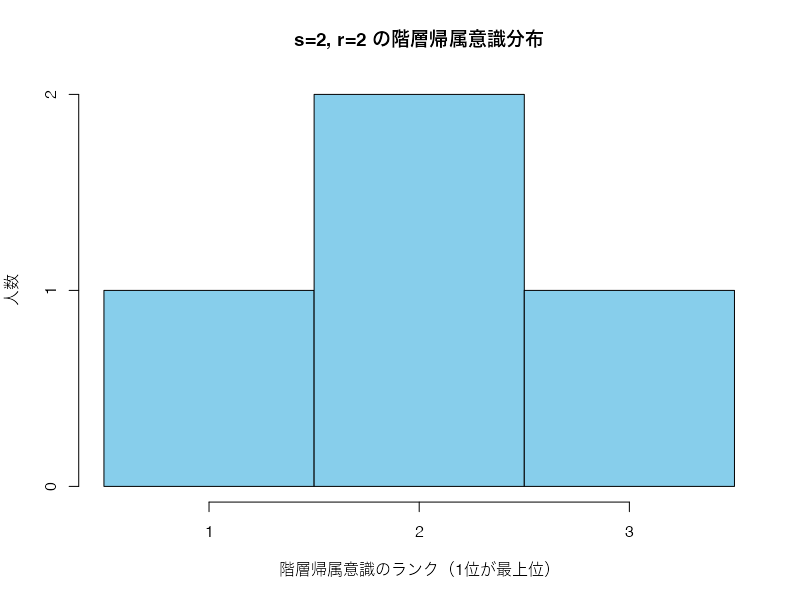

In [4]:
# 階層帰属意識の分布をヒストグラムで確認
cat("階層帰属意識（各行為者のランク）：", ci22, "\n")

hist(ci22,
     breaks = seq(0.5, max(ci22) + 0.5, 1),
     col    = "skyblue",
     xlab   = "階層帰属意識のランク（1位が最上位）",
     ylab   = "人数",
     main   = "s=2, r=2 の階層帰属意識分布",
     xaxt   = "n")
axis(1, at = 1:max(ci22))

> - 4人の行為者のうち，真ん中のランク（2位）に2人が集中する
> - 第12章の表や図で確認した通りの結果——「中意識集中現象」の萌芽がすでにここにある
> - $n = s(r-1)+1 = 2(2-1)+1 = 3$ 通りのランクが生じる（第13章の命題1）

---

## 14.3 次元数・ランク数を変えてみよう

次に，次元数 $s$・ランク数 $r$ を変えて，意識分布がどう変わるかを観察します．

第13章の命題によれば：
- 均衡イメージのランク数：$n = s(r-1) + 1$
- $s$ が大きいほど，分布は正規分布に近づく（中心極限定理的収束）

次元数 s = 3 ，ランク数 r = 2 
行為者数： 8 （= 2 ^ 3 ）
予測されるイメージランク数：n = 4 

実際のイメージランク数： 4 


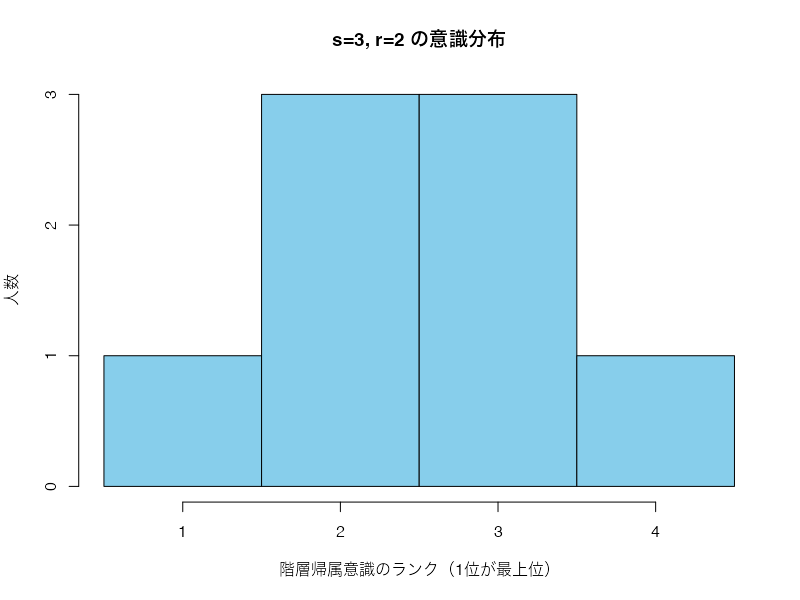

In [5]:
# ---- ここを変えてみよう ----
# s：次元数（階層の次元数，2・3・4 などを試してみよう）
# r：ランク数（各次元内のランク数，2・3 などを試してみよう）
s_try <- 3   # 次元数
r_try <- 2   # ランク数
# ----------------------------

# 客観階層構造の生成（s個の次元，各次元にr個のランク）
obj_try <- do.call(expand.grid, rep(list(r_try:1), s_try))
cat("次元数 s =", s_try, "，ランク数 r =", r_try, "\n")
cat("行為者数：", nrow(obj_try), "（=", r_try, "^", s_try, "）\n")
cat("予測されるイメージランク数：n =", s_try * (r_try - 1) + 1, "\n\n")

ci_try <- FK(obj_try, verbose = FALSE)
cat("実際のイメージランク数：", max(ci_try), "\n")

hist(ci_try,
     breaks = seq(0.5, max(ci_try) + 0.5, 1),
     col    = "skyblue",
     xlab   = "階層帰属意識のランク（1位が最上位）",
     ylab   = "人数",
     main   = paste0("s=", s_try, ", r=", r_try, " の意識分布"),
     xaxt   = "n")
axis(1, at = 1:max(ci_try))

---

## 14.4 次元数 $s$ による分布の変化（$r=2$ の場合）

$r=2$（2ランク）で次元数 $s$ を 2, 3, 4, 5 と増やしたとき，意識分布がどう変化するかを一覧で確認します．

$r=2$ のとき，各次元のランクは 0/1 の2値で，$\rho = \sum_{i=1}^s k_i$ は二項分布 $B(s, 1/2)$ に従います．
$s$ が大きくなると，二項分布は正規分布に近づきます（中心極限定理）．

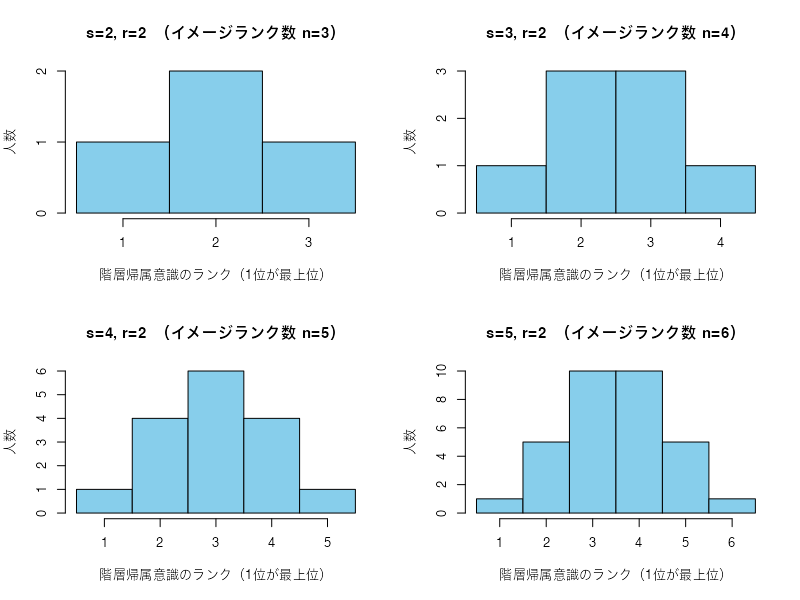

In [6]:
# r=2 固定で，s=2,3,4,5 の意識分布を並べて表示
s_vals <- c(2, 3, 4, 5)
r_fix  <- 2

par(mfrow = c(2, 2))  # 2×2のパネル配置

for (s in s_vals) {
  obj <- do.call(expand.grid, rep(list(r_fix:1), s))
  ci  <- FK(obj, verbose = FALSE)
  n_rank <- s * (r_fix - 1) + 1  # 理論上のランク数
  
  hist(ci,
       breaks = seq(0.5, max(ci) + 0.5, 1),
       col    = "skyblue",
       xlab   = "階層帰属意識のランク（1位が最上位）",
       ylab   = "人数",
       main   = paste0("s=", s, ", r=2  （イメージランク数 n=", n_rank, "）"),
       xaxt   = "n")
  axis(1, at = 1:max(ci))
}

par(mfrow = c(1, 1))

> - $s=2$：1:2:1 の三角形（中間が最多）
> - $s=3$：1:3:3:1（2項定理の係数＝パスカルの三角形）
> - $s=4, 5$：分布が鐘型に近づき，中位のランクに集中する傾向が強まる
> - $s \to \infty$ の極限では正規分布に収束する（中心極限定理）
> - これが「中意識集中現象」の数理的な説明：**多次元的な階層構造が存在するだけで，人びとは自動的に「中流」に集中する**

---

## 14.5 ランク数 $r$ を変えた場合の比較

今度は次元数 $s=3$ で固定し，ランク数 $r$ を 2, 3, 4 と変えてみます．

$r$ が大きくなるとランク数 $n = s(r-1)+1$ も増え，分布の形状はどう変わるでしょうか．

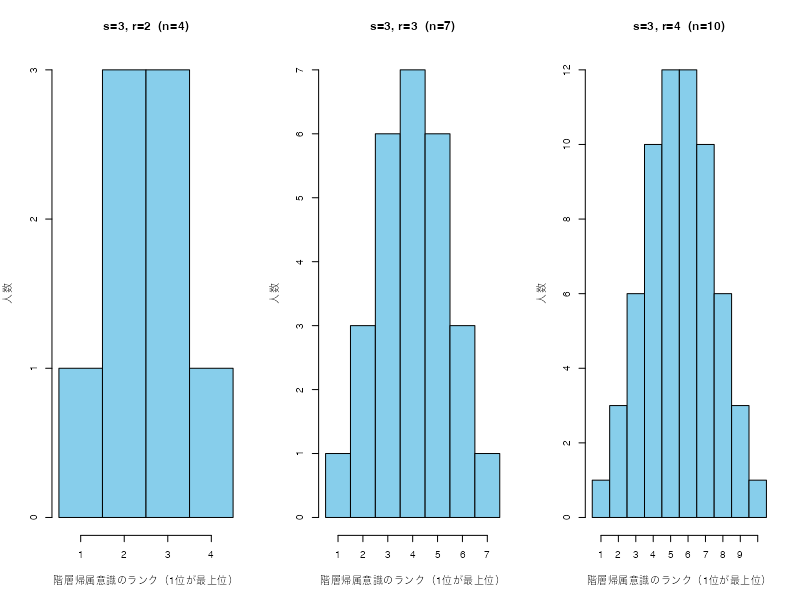

In [7]:
# s=3 固定で，r=2,3,4 の意識分布を比較
s_fix  <- 3
r_vals <- c(2, 3, 4)

par(mfrow = c(1, 3))

for (r in r_vals) {
  obj <- do.call(expand.grid, rep(list(r:1), s_fix))
  ci  <- FK(obj, verbose = FALSE)
  n_rank <- s_fix * (r - 1) + 1
  
  hist(ci,
       breaks = seq(0.5, max(ci) + 0.5, 1),
       col    = "skyblue",
       xlab   = "階層帰属意識のランク（1位が最上位）",
       ylab   = "人数",
       main   = paste0("s=3, r=", r, "  (n=", n_rank, ")"),
       xaxt   = "n")
  axis(1, at = 1:max(ci))
}

par(mfrow = c(1, 1))

> - $r=2$：二項分布型，鋭いピーク
> - $r=3$：第13章の一般公式 $f(\rho)$ に従う分布，ランク数が増えても中位集中
> - $r=4$：さらにランク数が増えるが，やはり中位のランクが最多
> - $r$ が何であれ，$s$ が大きければ中位集中が現れる——これがFKモデルの核心

---

## 14.6 まとめ：FKモデルと中意識集中現象

このシミュレーションを通じて，次のことが確認できました。

| 条件 | 分布の特徴 |
|------|------------|
| $s=2, r=2$ | 中位に2人集中（最小ケース） |
| $s$ 増加（$r=2$ 固定） | 二項分布 → 正規分布に収束，中位集中が強まる |
| $r$ 増加（$s$ 固定） | ランク数 $n$ が増えるが，中位集中の傾向は維持 |

**社会学的含意**：

FKモデルが解こうとしたパズルは，「なぜどの時代でも一貫した中意識集中現象が起きるのか」という問いだった．このシミュレーションで確認したように，レキシコグラフィカルな手がかり抽出（公理2）という認知ルールと，多次元的な客観階層構造（公理1）の組み合わせから，中意識集中は必然的な帰結として導かれる．

SSM調査が記録してきた「高度経済成長を達成した1975年以降，中の下がもっとも多い対称型の分布」は，職業・学歴といった複数次元の階層が存在する社会の構造的特性として理解できる．